<h3>This Jupyter Notebook is an assembled notebook that includes all members' work for a clear and neat presentation.<br></h3>

<h3>Work Allocation:<br></h3>
Raymond Lu (z5277884): Multinomial Naive Bayes Model<br>
Ziyang Liang: Decision Tree Classifier Model<br>
Yangqi Zhang(z5235062): Support Vector Classification Model<br>
Yunze Shi(): Logistic Regression Model<br>
Yinong Wang: Neural Network, Ensemble Model Design <br>
<br>
All: Text Report, Assembled Notebook


<h2> NOTE: Some cells in this notebook are copied and pasted from notebooks of members' work.

In [12]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.utils import shuffle
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from varname import varname
from collections import Counter
%matplotlib inline
#fix random seed
np.random.seed(1)

In [3]:
# !jupyter nbextension enable vega --py --sys-prefix

# 1.Model Construction

## 1.1Data Analysis

### 1.1.1Data Import

In [7]:
TRAINING_FILE = "../training.csv"
TEST_FILE = "../test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
print(df_test.isnull().sum())
df_train.head(5)

article_number    0
article_words     0
topic             0
dtype: int64
article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


From the result above, it could be seen that there are no *null* values in either training data set or test data set. And the topic feature is supposed to be predicted by article_words feature.

### 1.1.2Plot Data Distribution

In [8]:
data_x = df.article_words
data_y = df.topic

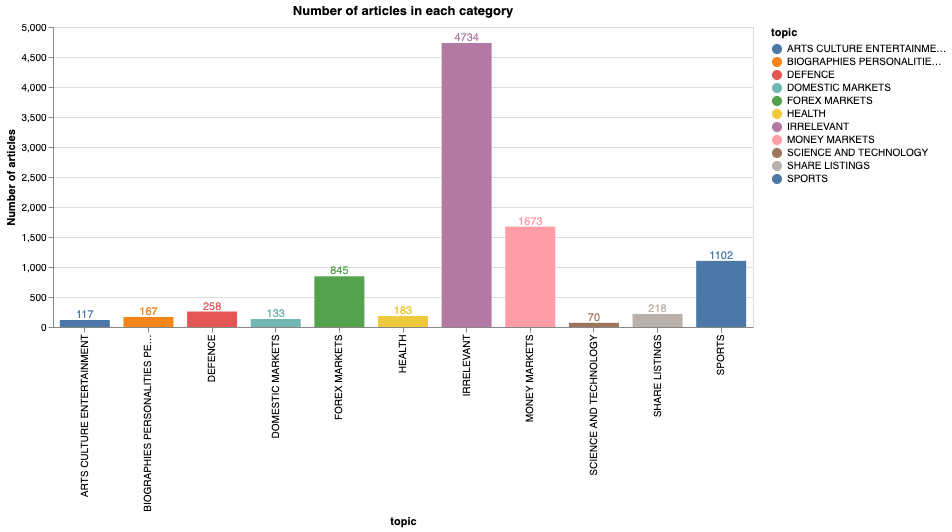

In [244]:
alt.data_transformers.disable_max_rows()
bars = alt.Chart(data_y.to_frame()).mark_bar(size=50).encode(
x=alt.X("topic"),
y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
tooltip=[alt.Tooltip('count()', title='Number of articles'), 'topic'],
color='topic'

)

text = bars.mark_text(
align='center',
baseline='bottom',
).encode(
text='count()'
)

(bars + text).properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)

From the plot above, it could be seen that the data distribution in the training data set is severely imbalanced, with **IRRELEVANT** topic occupies more than half amount.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 11 Text major ticklabel objects>)

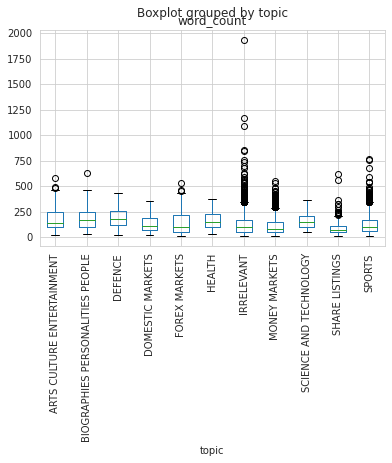

In [9]:
data = df
data['word_count'] = data.article_words.str.count(",")+1
data.boxplot(column ='word_count',by ='topic')
plt.xticks(rotation=90)

From the boxplot above, it could be seen that the variance of word count in **IRRELEVANT** topic is far higher than other topics. This means that the word count of **IRRELEVANT** topic varies in a substantial range.

### 1.1.3 Key Word Analysis for Each Topic

In [10]:
def word_count_function(word_list,topic_df):
    #return the only the words in word_list occur in the topic_df
    occurence_df = pd.DataFrame() #show their occurence in other topics 
    for words in word_list:
        occurence_dict = {}
        for name, group in topic_df :
            word_counter = Counter(" ".join(group["article_words"]).split(","))
            occurence = word_counter[words]
            avg_occurence = occurence / len(group)
            occurence_dict.update({name:avg_occurence})
        occur_series = pd.Series(occurence_dict) 
        occur_series.name = words
        occurence_df = occurence_df.append(occur_series, ignore_index = True)
    return(occurence_df.T)

In [14]:
#finding the most frequent words in training set by topics
topic_group = df_train.groupby('topic')
most_frequent_word_list = {}
word_list_10 = []
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(10)
    most_frequent_word_list.update({name:frequent_words})
    common_words = [i[0] for i in frequent_words]
    word_list_10 = word_list_10 + common_words
print(most_frequent_word_list)

{'ARTS CULTURE ENTERTAINMENT': [('year', 156), ('film', 153), ('million', 102), ('stat', 83), ('work', 81), ('offic', 80), ('show', 72), ('releas', 72), ('peopl', 70), ('music', 69)], 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249), ('presid', 198), ('yeltsin', 140), ('stat', 133), ('hospit', 124), ('offic', 122), ('lead', 121), ('minist', 119), ('told', 117), ('report', 113)], 'DEFENCE': [('nato', 511), ('stat', 410), ('milit', 406), ('forc', 381), ('defend', 357), ('minist', 345), ('offic', 317), ('russia', 299), ('presid', 238), ('plan', 235)], 'DOMESTIC MARKETS': [('import', 541), ('ton', 324), ('percent', 265), ('year', 262), ('oil', 191), ('trad', 189), ('chin', 186), ('export', 161), ('million', 151), ('produc', 140)], 'FOREX MARKETS': [('dollar', 3358), ('bank', 2178), ('rate', 1720), ('trad', 1671), ('market', 1662), ('percent', 1336), ('currenc', 1214), ('deal', 1208), ('mark', 1191), ('yen', 962)], 'HEALTH': [('year', 253), ('health', 245), ('stat', 241), ('diseas', 184),

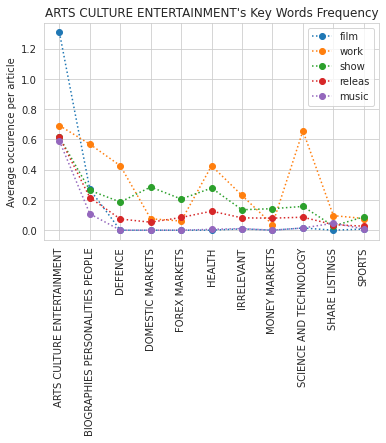

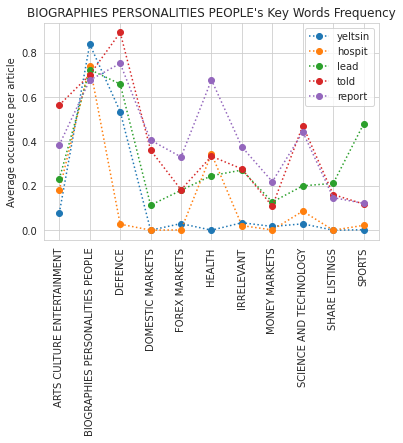

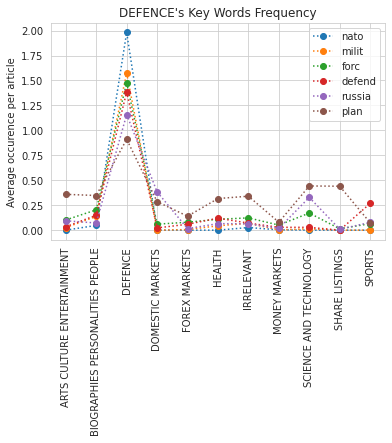

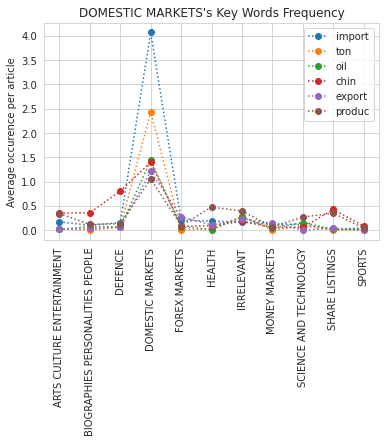

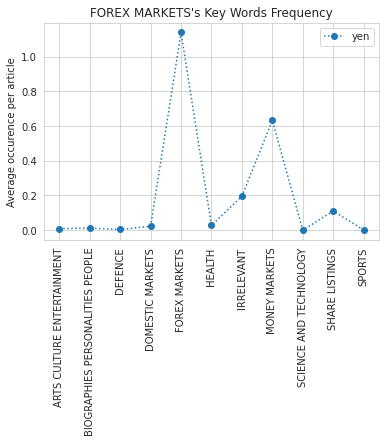

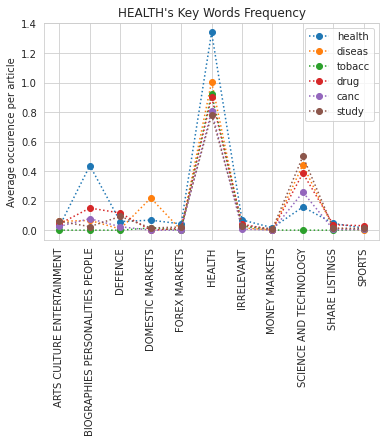

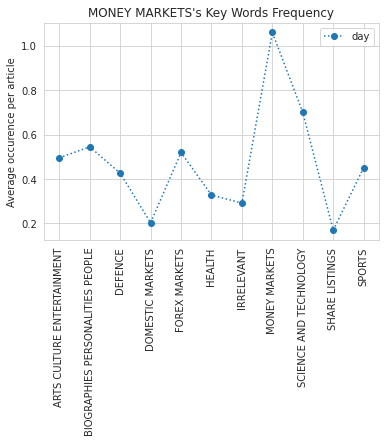

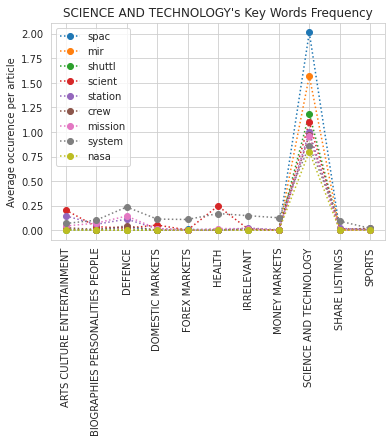

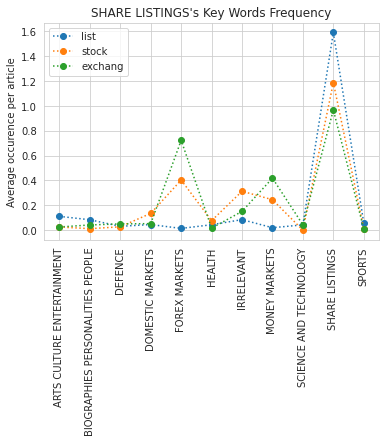

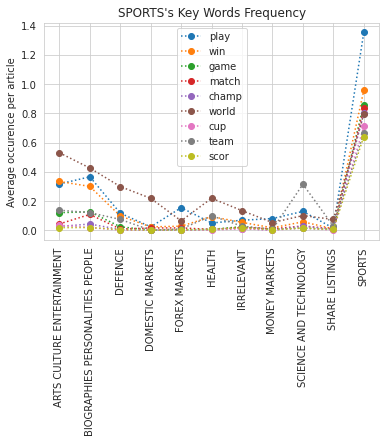

In [15]:
word_list_group = [ [i for i in word_list_10[j*10 :(j+1)*10 ] if word_list_10.count(i) == 1] for j in range(11) ]
#visaulize key word's performance
for i in range(11):
    if i == 6:
        continue #irrelevant do not have any words
    my_words = word_list_group[i]
    my_df = word_count_function(my_words,topic_group)
    
    my_df.columns = my_words
    my_df.plot(marker='o',style = ':')
    plt.xticks(np.arange(11), list(my_df.index),rotation=90)

    plt.title(list(my_df.index)[i] + '\'s Key Words Frequency')
    plt.ylabel('Average occurence per article')
    plt.show()

The plots above shows for each topic, how is the distribution of its own top key words among all topics other than **IRRELEVANT**. It could be seen that for **BIOGRAPHIES PERSONALITIES PEOPLE**, its top key words' occurences are not distinguishing from the ones of other topics. Worse still, its two key words, *told* and *report* have higer occurence in other topics. This indicates that, the prediction of **BIOGRAPHIES PERSONALITIES PEOPLE** would be in poor quality since this topic's features are not characteristical. <br><br>
In contrast, **DEFENCE**, **SHARE LISTING** and **SPORTS** are supposed to have ideal predictions on account that all their corresponding key words' occurences are obviously lower among other topics.

## 1.2 Solve Data Imbalance

In order to generate precise models, the data imbalance needs to be solved. Otherwise, the generated models are more likely to predict the results to be the majority topic in the training set. For the purpose of eliminating such bias, SMOTE (Synthetic Minority Oversampling Technique) is introduced to solve this problem.

*SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.*<br>
<div style="text-align:right">— Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.</div>

*Below is the fraction of code used later that using SMOTE to solve the imbalance problem.

In [ ]:
# ! DON'T RUN THIS CELL!!!!!!!!!!!!!
# Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])

*"train_x"* is a Numpy array that stores article words in the training data set, and *"en_train_y"* is encoded topics from the training set. After *train_x* getting vectorized, SMOTE augments the vectors of *train_vectors* and *en_train_y* to be *smo_x* and *smo_y*.

## 1.3 Multinomial Naive Bayes Model

### Functions

In [18]:
# Get scores for a particular model
def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
    
def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

# Show each topic's f1, accuracy and recall scores
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

# For an individual topic, get its f1, accuracy and recall scores        
def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
# Combine pipeline and GridSearchCV together
# Since grid search is time-consuming, the range of each elements in the parameter grid is 
# comparatively small
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
                "vectorizer__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)

# SMOTE the training data with vectorizer
def smote_data(df_train,vectorizer):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    return(new_train_x,smo_y,topics,le,encode_mapping)

# get a model that the training data is SMOTEd with vectorizer
def get_model(df_train,vectorizer):
    new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,vectorizer)
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)

# test the model's accuracy with dataframe named df_test      
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

### 1.3.1 Two Layer Model Construction

We construct 